<a href="https://colab.research.google.com/github/yualapshina/nlp-lab1/blob/master/nlp_lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [436]:
import csv
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain
from wordcloud import WordCloud
from textblob import TextBlob
from gensim.models import FastText

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier

import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import layers

In [216]:
nltk.download('wordnet', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

True

# 1. изучение и обработка данных

In [217]:
!git clone https://github.com/yualapshina/nlp-lab1.git  --quiet

fatal: destination path 'nlp-lab1' already exists and is not an empty directory.


In [218]:
df_train = pd.read_csv('nlp-lab1/train_data.csv')
df_test = pd.read_csv('nlp-lab1/test_data.csv')
df_test['Sentiment'] = 'unknown'
df = pd.concat([df_train, df_test], ignore_index=True)
df

,Unnamed: 0,Date Created,Number of Likes,Source of Tweet,Tweet,Sentiment
0,0,2022-11-20 16:13:23+00:00,1,Twitter for iPhone,God damn! @JioCinema we have to watch the #Wor...,negative
1,1,2022-11-20 18:59:03+00:00,0,Twitter Web App,The World Cup begins!\n\n#madeit #WorldCup2022...,positive
2,2,2022-11-20 14:44:21+00:00,0,Twitter Web App,Need help with;\n√maths\n√finance\n√economics\...,neutral
3,3,2022-11-20 11:55:59+00:00,0,Twitter for Android,Happy #WorldCup2022 day!!!!!,positive
4,4,2022-11-20 16:11:21+00:00,1,Twitter Web App,aaaaaand all the rumors that Qatar paid off #E...,neutral
...,...,...,...,...,...,...
22519,2519,2022-11-20 15:43:17+00:00,1,Twitter for Android,"Many Refugees die before reaching Europe, many...",unknown
22520,2520,2022-11-20 18:52:18+00:00,15,Twitter for Android,"Qatar has a lot of money, but they definitely ...",unknown
22521,2521,2022-11-20 16:10:21+00:00,0,Twitter for iPhone,OHHHHHHHH YESSSSSSSSSS HERE WE GO!!!’ \n\nBack...,unknown
22522,2522,2022-11-20 09:51:54+00:00,13,Twitter for iPhone,So far I’m as excited about this #WorldCup2022...,unknown


In [219]:
# избавляемся от дублирования индексов
df = df.drop(columns=['Unnamed: 0'])
df

,Date Created,Number of Likes,Source of Tweet,Tweet,Sentiment
0,2022-11-20 16:13:23+00:00,1,Twitter for iPhone,God damn! @JioCinema we have to watch the #Wor...,negative
1,2022-11-20 18:59:03+00:00,0,Twitter Web App,The World Cup begins!\n\n#madeit #WorldCup2022...,positive
2,2022-11-20 14:44:21+00:00,0,Twitter Web App,Need help with;\n√maths\n√finance\n√economics\...,neutral
3,2022-11-20 11:55:59+00:00,0,Twitter for Android,Happy #WorldCup2022 day!!!!!,positive
4,2022-11-20 16:11:21+00:00,1,Twitter Web App,aaaaaand all the rumors that Qatar paid off #E...,neutral
...,...,...,...,...,...
22519,2022-11-20 15:43:17+00:00,1,Twitter for Android,"Many Refugees die before reaching Europe, many...",unknown
22520,2022-11-20 18:52:18+00:00,15,Twitter for Android,"Qatar has a lot of money, but they definitely ...",unknown
22521,2022-11-20 16:10:21+00:00,0,Twitter for iPhone,OHHHHHHHH YESSSSSSSSSS HERE WE GO!!!’ \n\nBack...,unknown
22522,2022-11-20 09:51:54+00:00,13,Twitter for iPhone,So far I’m as excited about this #WorldCup2022...,unknown


In [220]:
# проверяем на недостающие значения: всё в порядке
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22524 entries, 0 to 22523
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Date Created     22524 non-null  object
 1   Number of Likes  22524 non-null  int64 
 2   Source of Tweet  22524 non-null  object
 3   Tweet            22524 non-null  object
 4   Sentiment        22524 non-null  object
dtypes: int64(1), object(4)
memory usage: 880.0+ KB


In [221]:
# причёсываем текст
stopwords = stopwords.words('english')
tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

df['Tweet'] = df['Tweet'].str.lower().replace(r"http\S+", "", regex=True).replace('[^A-Za-z0-9]+', ' ', regex=True)
df['Tweet'] = df['Tweet'].apply(lambda text: ' '.join(word.lower() for word in text.split() if word not in stopwords))
df['Tokens'] = df['Tweet'].apply(lambda text: [lemmatizer.lemmatize(word) for word in tokenizer.tokenize(text)])
df

,Date Created,Number of Likes,Source of Tweet,Tweet,Sentiment,Tokens
0,2022-11-20 16:13:23+00:00,1,Twitter for iPhone,god damn jiocinema watch worldcup2022 slow mot...,negative,"[god, damn, jiocinema, watch, worldcup2022, sl..."
1,2022-11-20 18:59:03+00:00,0,Twitter Web App,world cup begins madeit worldcup2022 football ...,positive,"[world, cup, begin, madeit, worldcup2022, foot..."
2,2022-11-20 14:44:21+00:00,0,Twitter Web App,need help maths finance economics calculus sta...,neutral,"[need, help, math, finance, economics, calculu..."
3,2022-11-20 11:55:59+00:00,0,Twitter for Android,happy worldcup2022 day,positive,"[happy, worldcup2022, day]"
4,2022-11-20 16:11:21+00:00,1,Twitter Web App,aaaaaand rumors qatar paid ecu first game talk...,neutral,"[aaaaaand, rumor, qatar, paid, ecu, first, gam..."
...,...,...,...,...,...,...
22519,2022-11-20 15:43:17+00:00,1,Twitter for Android,many refugees die reaching europe many drown j...,unknown,"[many, refugee, die, reaching, europe, many, d..."
22520,2022-11-20 18:52:18+00:00,15,Twitter for Android,qatar lot money definitely play football buy e...,unknown,"[qatar, lot, money, definitely, play, football..."
22521,2022-11-20 16:10:21+00:00,0,Twitter for iPhone,ohhhhhhhh yessssssssss go back april came viru...,unknown,"[ohhhhhhhh, yes, go, back, april, came, virus,..."
22522,2022-11-20 09:51:54+00:00,13,Twitter for iPhone,far excited worldcup2022 benjamin white,unknown,"[far, excited, worldcup2022, benjamin, white]"


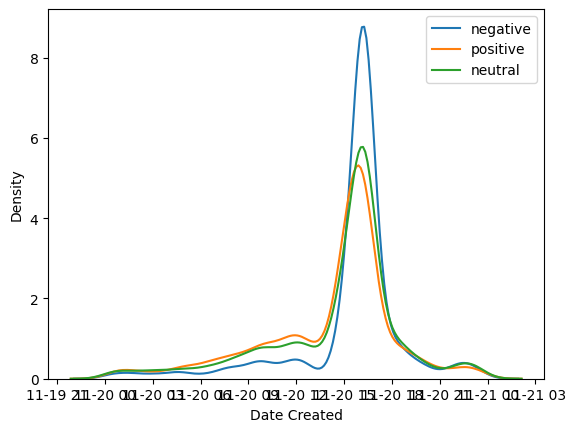

In [222]:
# взаимосвязь класса с датой:
df['Date Created'] = pd.to_datetime(df['Date Created'])
for s in df['Sentiment'].unique():
  if s == 'unknown':
    continue
  sns.kdeplot(df.loc[(df['Sentiment'] == s), 'Date Created'], label=s)
  plt.legend()
plt.show()
# так сказать, начали за здравие...
# достаточно полезный признак, при этом не цикличный, как обычно бывает время, а достаточно прямолинейный,
# поэтому для удобства мы можем его перекодировать в удобный интервал
df['Timedelta'] = df['Date Created'].apply(lambda x: (x - np.min(df['Date Created'])).total_seconds())
df = df.drop(columns=['Date Created'])

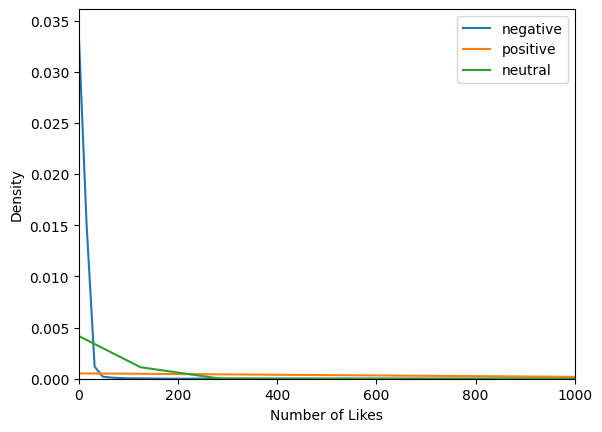

In [223]:
# взаимосвязь класса с количеством лайков:
for s in df['Sentiment'].unique():
  if s == 'unknown':
    continue
  sns.kdeplot(df.loc[(df['Sentiment'] == s), 'Number of Likes'], label=s)
  plt.legend()
  plt.xlim((0, 1000))
plt.show()
# распределение просто абсурдное, это для нас кстати

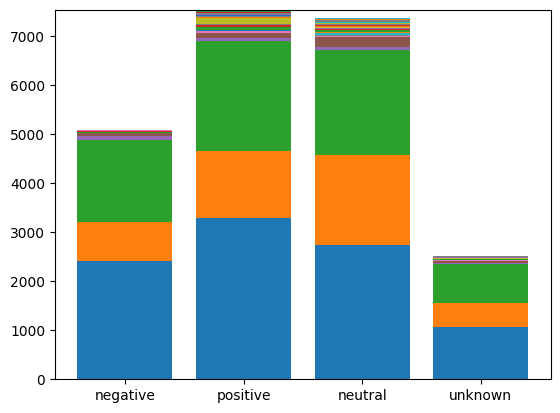

In [224]:
# взаимосвязь класса и устройства:
bottom = np.zeros(len(df['Sentiment'].unique()))
for src in df['Source of Tweet'].unique():
  data = []
  for s in df['Sentiment'].unique():
    data.append(len(df[(df['Source of Tweet'] == src) & (df['Sentiment'] == s)]))
  plt.bar(df['Sentiment'].unique(), data, bottom=bottom, label=src)
  bottom += data
plt.show()
# признак едва ли несёт в себе что-то полезное для нашей задачи
df = df.drop(columns=['Source of Tweet'])

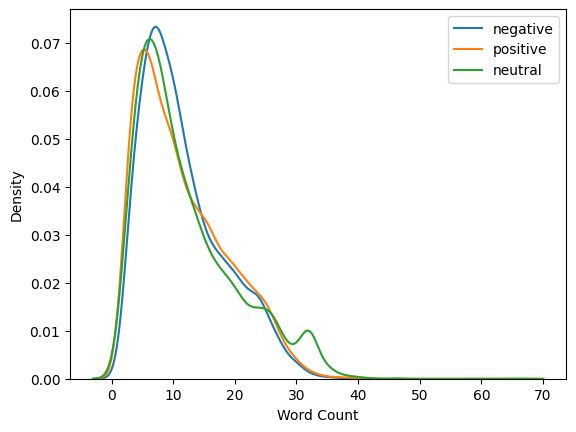

In [225]:
# взаимосвязь класса с длиной твита:
df['Word Count'] = df['Tokens'].apply(len)
for s in df['Sentiment'].unique():
  if s == 'unknown':
    continue
  sns.kdeplot(df.loc[(df['Sentiment'] == s), 'Word Count'], label=s)
  plt.legend()
plt.show()
# в целом похоже, но пара отличий есть, может пригодиться

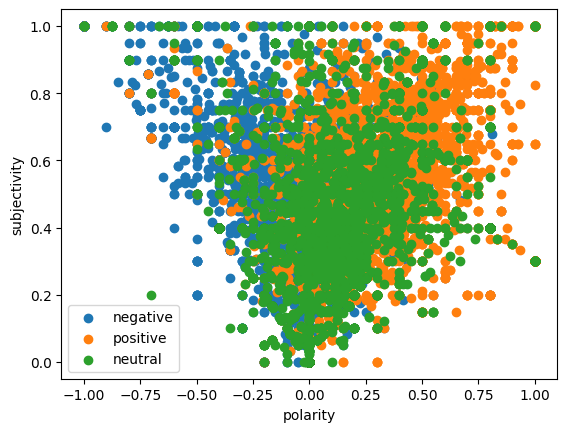

In [226]:
# взаимосвязь класса, полярности и субъективности:
df['Polarity'] = df['Tweet'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['Subjectivity'] = df['Tweet'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
for s in df['Sentiment'].unique():
  if s == 'unknown':
    continue
  ix = np.where(df['Sentiment'] == s)
  plt.scatter(df.loc[ix, 'Polarity'], df.loc[ix, 'Subjectivity'], label=s)
plt.xlabel('polarity')
plt.ylabel('subjectivity')
plt.legend()
plt.show()
# текстблоб знает своё дело
# связь с полярностью достаточно сильная
# с субъективностью меньше, но в целом прослеживается уменьшение нейтральных, так что ок

In [227]:
# полюбуемся теперь на облака слов
# для начала выберем самые распространённые слова, чтобы они нам не мешали
wordcloud = WordCloud(collocations=False).generate(' '.join(list(chain.from_iterable(df['Tokens']))))
mainstream = dict(filter(lambda item: item[1] > 0.1, sorted(wordcloud.words_.items(), key=lambda item: item[1], reverse=True)))
mainstream

{'worldcup2022': 1.0,
 'qatar': 0.2735281097830899,
 'world': 0.2727312970340859,
 'cup': 0.24971226206285968,
 'fifaworldcup': 0.16609119079238602,
 'worldcup': 0.14590526781761842,
 'qatar2022': 0.12350597609561753,
 'ecuador': 0.11049136786188579,
 'fifa': 0.10212483399734396}

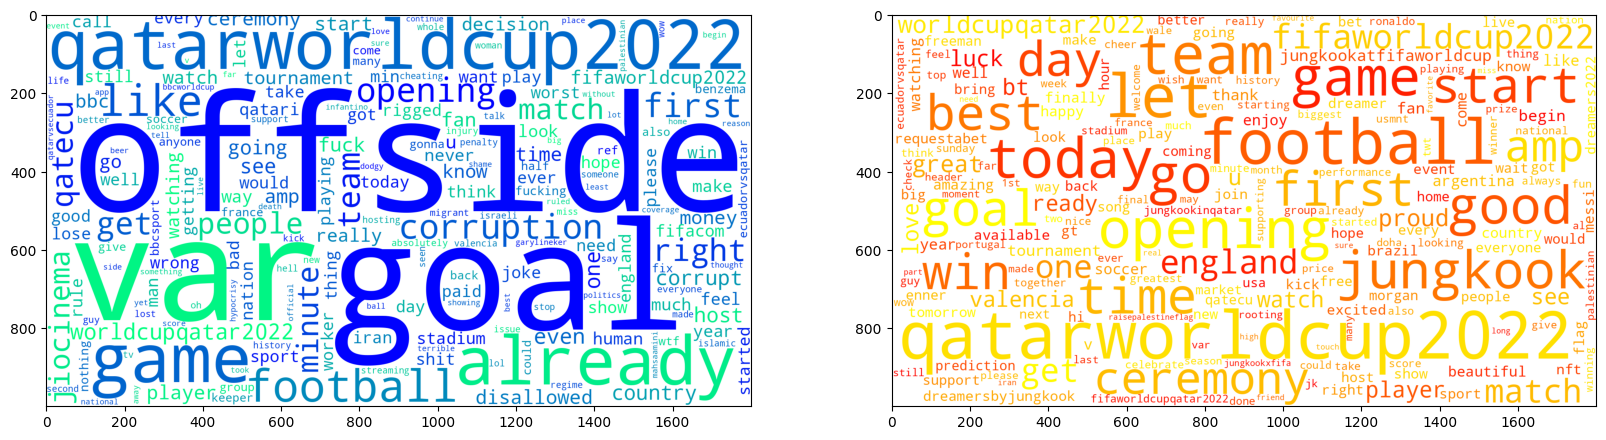

In [228]:
# посмотрим теперь на разницу классов без учёта этих общих слов
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
wordcloud = WordCloud(
    width=1800,
    height=1000,
    min_font_size=10,
    background_color='white',
    colormap='winter',
    collocations=False,
    stopwords=mainstream.keys())
wordcloud.generate(' '.join(list(chain.from_iterable(df['Tokens'][df['Sentiment'] == 'negative']))))
ax1.imshow(wordcloud)
wordcloud = WordCloud(
    width=1800,
    height=1000,
    min_font_size=10,
    background_color='white',
    colormap='autumn',
    collocations=False,
    stopwords=mainstream.keys())
wordcloud.generate(' '.join(list(chain.from_iterable(df['Tokens'][df['Sentiment'] == 'positive']))))
ax2.imshow(wordcloud)
# люди не любят коррупцию и любят Чонгука.
# а если серьёзно, люди любят церемонию открытия и не любят судейские решения,
# что совпадает с нашим анализом таймстемпов

In [229]:
# Наконец, представим слова в векторном виде
tokens = df['Tokens']
model = FastText(vector_size=100, seed=88)
model.build_vocab(tokens)
model.train(tokens, total_examples=len(tokens), epochs=model.epochs)

(917210, 1328590)

In [230]:
vectors = model.wv
vectors.most_similar('worldcupqatar2022', topn=10)

[('qatar2022worldcup', 0.9916115999221802),
 ('qatarworldcuphd', 0.9915410876274109),
 ('qatarworldcup2022', 0.9908435940742493),
 ('worldcupqatar', 0.9903859496116638),
 ('fifaworldcup2022qatar', 0.9887607097625732),
 ('fifaworldcupqatar', 0.9885565042495728),
 ('qatarworldcup', 0.9879673719406128),
 ('fifaworldcupqatar2022', 0.9875333309173584),
 ('qutarworldcup', 0.9866577982902527),
 ('quatarworldcup2022', 0.9835494756698608)]

In [231]:
# каждый твит будет представлен усреднённым векторов его слов
df['Vector'] = df['Tokens'].apply(lambda x: sum(vectors[x]) / len(x))
df['Mean Vector'] = df['Vector'].apply(lambda x: sum(x) / len(x))
df = df.drop(columns=['Vector'])
df_base = df
df

,Number of Likes,Tweet,Sentiment,Tokens,Timedelta,Word Count,Polarity,Subjectivity,Mean Vector
0,1,god damn jiocinema watch worldcup2022 slow mot...,negative,"[god, damn, jiocinema, watch, worldcup2022, sl...",58403.0,13,-0.225000,0.575000,0.017660
1,0,world cup begins madeit worldcup2022 football ...,positive,"[world, cup, begin, madeit, worldcup2022, foot...",68343.0,7,0.000000,0.000000,-0.014937
2,0,need help maths finance economics calculus sta...,neutral,"[need, help, math, finance, economics, calculu...",53061.0,21,-0.125000,0.375000,-0.003381
3,0,happy worldcup2022 day,positive,"[happy, worldcup2022, day]",42959.0,3,0.800000,1.000000,0.015575
4,1,aaaaaand rumors qatar paid ecu first game talk...,neutral,"[aaaaaand, rumor, qatar, paid, ecu, first, gam...",58281.0,11,-0.075000,0.366667,-0.006476
...,...,...,...,...,...,...,...,...,...
22519,1,many refugees die reaching europe many drown j...,unknown,"[many, refugee, die, reaching, europe, many, d...",56597.0,22,0.460000,0.500000,-0.007089
22520,15,qatar lot money definitely play football buy e...,unknown,"[qatar, lot, money, definitely, play, football...",67938.0,9,0.000000,0.500000,0.003836
22521,0,ohhhhhhhh yessssssssss go back april came viru...,unknown,"[ohhhhhhhh, yes, go, back, april, came, virus,...",58221.0,20,0.000000,0.000000,0.004663
22522,13,far excited worldcup2022 benjamin white,unknown,"[far, excited, worldcup2022, benjamin, white]",35514.0,5,0.158333,0.583333,0.006210


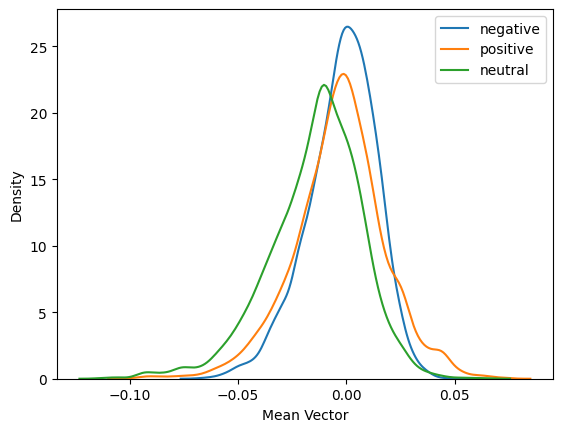

In [232]:
# попробуем понять, что мы там наобучали и наусредняли
for s in df['Sentiment'].unique():
  if s == 'unknown':
    continue
  sns.kdeplot(df.loc[(df['Sentiment'] == s), 'Mean Vector'], label=s)
  plt.legend()
plt.show()
# похоже на распределение по времени, нормально.

# 2. алгоритмы машинного обучения

In [233]:
df = df_base.drop(columns=['Tweet', 'Tokens'])
df

,Number of Likes,Sentiment,Timedelta,Word Count,Polarity,Subjectivity,Mean Vector
0,1,negative,58403.0,13,-0.225000,0.575000,0.017660
1,0,positive,68343.0,7,0.000000,0.000000,-0.014937
2,0,neutral,53061.0,21,-0.125000,0.375000,-0.003381
3,0,positive,42959.0,3,0.800000,1.000000,0.015575
4,1,neutral,58281.0,11,-0.075000,0.366667,-0.006476
...,...,...,...,...,...,...,...
22519,1,unknown,56597.0,22,0.460000,0.500000,-0.007089
22520,15,unknown,67938.0,9,0.000000,0.500000,0.003836
22521,0,unknown,58221.0,20,0.000000,0.000000,0.004663
22522,13,unknown,35514.0,5,0.158333,0.583333,0.006210


In [234]:
df_train, df_test = [x for _, x in df.groupby(df['Sentiment'] == 'unknown')]
x_test = df_test.drop(columns=['Sentiment'])
x_train = df_train.drop(columns=['Sentiment'])
y_train = df_train['Sentiment']
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.33, random_state=88)

In [235]:
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_valid = sc.transform(x_valid)
x_test = sc.transform(x_test)

In [236]:
lrc = LogisticRegression(random_state=88).fit(x_train, y_train)
lrc.score(x_valid, y_valid)

0.5565151515151515

In [237]:
sgd = SGDClassifier(random_state=88).fit(x_train, y_train)
sgd.score(x_valid, y_valid)

0.5416666666666666

In [238]:
svc = SVC(random_state=88).fit(x_train, y_train)
svc.score(x_valid, y_valid)

0.5731818181818182

In [239]:
stc = StackingClassifier(estimators=[
    ('sgd', SGDClassifier(random_state=88)),
    ('svc', SVC(random_state=88)),
], final_estimator=LogisticRegression(random_state=88, max_iter=500)).fit(x_train, y_train)
stc.score(x_valid, y_valid)

0.5725757575757576

# 3. алгоритмы глубинного обучения

In [402]:
df = df_base
df

,Number of Likes,Tweet,Sentiment,Tokens,Timedelta,Word Count,Polarity,Subjectivity,Mean Vector
0,1,god damn jiocinema watch worldcup2022 slow mot...,negative,"[god, damn, jiocinema, watch, worldcup2022, sl...",58403.0,13,-0.225000,0.575000,0.017660
1,0,world cup begins madeit worldcup2022 football ...,positive,"[world, cup, begin, madeit, worldcup2022, foot...",68343.0,7,0.000000,0.000000,-0.014937
2,0,need help maths finance economics calculus sta...,neutral,"[need, help, math, finance, economics, calculu...",53061.0,21,-0.125000,0.375000,-0.003381
3,0,happy worldcup2022 day,positive,"[happy, worldcup2022, day]",42959.0,3,0.800000,1.000000,0.015575
4,1,aaaaaand rumors qatar paid ecu first game talk...,neutral,"[aaaaaand, rumor, qatar, paid, ecu, first, gam...",58281.0,11,-0.075000,0.366667,-0.006476
...,...,...,...,...,...,...,...,...,...
22519,1,many refugees die reaching europe many drown j...,unknown,"[many, refugee, die, reaching, europe, many, d...",56597.0,22,0.460000,0.500000,-0.007089
22520,15,qatar lot money definitely play football buy e...,unknown,"[qatar, lot, money, definitely, play, football...",67938.0,9,0.000000,0.500000,0.003836
22521,0,ohhhhhhhh yessssssssss go back april came viru...,unknown,"[ohhhhhhhh, yes, go, back, april, came, virus,...",58221.0,20,0.000000,0.000000,0.004663
22522,13,far excited worldcup2022 benjamin white,unknown,"[far, excited, worldcup2022, benjamin, white]",35514.0,5,0.158333,0.583333,0.006210


In [433]:
onehot = {
    'negative': [1,0,0],
    'neutral': [0,1,0],
    'positive': [0,0,1],
}
reverse = {
    0: 'negative',
    1: 'neutral',
    2: 'positive',
}

In [404]:
df_train, df_test = [x for _, x in df.groupby(df['Sentiment'] == 'unknown')]

max_length = np.max(df['Word Count'])
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train['Tokens'])

encodes = tokenizer.texts_to_sequences(df_train['Tokens'])
x_train = pad_sequences(encodes, maxlen=max_length, padding='post')
y_train = np.array(df_train['Sentiment'].apply(lambda x: np.array(onehot[x])))
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.33, random_state=88)

encodes = tokenizer.texts_to_sequences(df_test['Tokens'])
x_test = pad_sequences(encodes, maxlen=max_length, padding='post')

y_train = tf.convert_to_tensor(list(y_train))
y_valid = tf.convert_to_tensor(list(y_valid))

In [425]:
cnn = Sequential([
    layers.Embedding(
        len(tokenizer.word_index) + 1,
        100,
        input_length=max_length),
    layers.Conv1D(filters=32, kernel_size=8, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(3, activation='sigmoid')
])
cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn.fit(x_train, y_train, batch_size=64, epochs=15, verbose=2)

Epoch 1/15
210/210 - 11s - loss: 0.9014 - accuracy: 0.5489 - 11s/epoch - 54ms/step
Epoch 2/15
210/210 - 11s - loss: 0.4923 - accuracy: 0.8000 - 11s/epoch - 52ms/step
Epoch 3/15
210/210 - 11s - loss: 0.2530 - accuracy: 0.9055 - 11s/epoch - 51ms/step
Epoch 4/15
210/210 - 11s - loss: 0.1404 - accuracy: 0.9515 - 11s/epoch - 52ms/step
Epoch 5/15
210/210 - 11s - loss: 0.0921 - accuracy: 0.9668 - 11s/epoch - 51ms/step
Epoch 6/15
210/210 - 11s - loss: 0.0660 - accuracy: 0.9751 - 11s/epoch - 52ms/step
Epoch 7/15
210/210 - 10s - loss: 0.0498 - accuracy: 0.9813 - 10s/epoch - 48ms/step
Epoch 8/15
210/210 - 10s - loss: 0.0404 - accuracy: 0.9840 - 10s/epoch - 50ms/step
Epoch 9/15
210/210 - 11s - loss: 0.0364 - accuracy: 0.9863 - 11s/epoch - 51ms/step
Epoch 10/15
210/210 - 11s - loss: 0.0316 - accuracy: 0.9879 - 11s/epoch - 51ms/step
Epoch 11/15
210/210 - 11s - loss: 0.0309 - accuracy: 0.9884 - 11s/epoch - 51ms/step
Epoch 12/15
210/210 - 11s - loss: 0.0280 - accuracy: 0.9887 - 11s/epoch - 51ms/step
E

In [426]:
cnn.evaluate(x_valid, y_valid)
# не блестяще, но явно намного лучше

207/207 [==============================] - 2s 7ms/step - loss: 1.8942 - accuracy: 0.6792


[1.8942146301269531, 0.6792424321174622]

In [427]:
lstm = Sequential([
    layers.Embedding(
        len(tokenizer.word_index) + 1,
        100,
        input_length=max_length),
    layers.Bidirectional(layers.LSTM(64)),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='sigmoid')
])
lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm.fit(x_train, y_train, batch_size=64, epochs=15, verbose=2)

Epoch 1/15
210/210 - 46s - loss: 0.8312 - accuracy: 0.5983 - 46s/epoch - 217ms/step
Epoch 2/15
210/210 - 41s - loss: 0.4696 - accuracy: 0.8127 - 41s/epoch - 197ms/step
Epoch 3/15
210/210 - 40s - loss: 0.3181 - accuracy: 0.8796 - 40s/epoch - 191ms/step
Epoch 4/15
210/210 - 39s - loss: 0.2352 - accuracy: 0.9137 - 39s/epoch - 188ms/step
Epoch 5/15
210/210 - 39s - loss: 0.1831 - accuracy: 0.9299 - 39s/epoch - 188ms/step
Epoch 6/15
210/210 - 40s - loss: 0.1587 - accuracy: 0.9394 - 40s/epoch - 191ms/step
Epoch 7/15
210/210 - 41s - loss: 0.1309 - accuracy: 0.9496 - 41s/epoch - 193ms/step
Epoch 8/15
210/210 - 39s - loss: 0.1169 - accuracy: 0.9557 - 39s/epoch - 188ms/step
Epoch 9/15
210/210 - 39s - loss: 0.1057 - accuracy: 0.9571 - 39s/epoch - 188ms/step
Epoch 10/15
210/210 - 39s - loss: 0.0988 - accuracy: 0.9604 - 39s/epoch - 187ms/step
Epoch 11/15
210/210 - 39s - loss: 0.0957 - accuracy: 0.9616 - 39s/epoch - 187ms/step
Epoch 12/15
210/210 - 39s - loss: 0.0831 - accuracy: 0.9663 - 39s/epoch - 

In [428]:
lstm.evaluate(x_valid, y_valid)
# по-хорошему, стоило бы ещё поиграть с гиперпараметрами
# но общая идея понятна

207/207 [==============================] - 6s 23ms/step - loss: 1.7242 - accuracy: 0.6783


[1.724226713180542, 0.6783333420753479]

In [439]:
pred = cnn.predict(x_test)

with open('nlp-lab1/submit.csv','w') as output:
    writer = csv.writer(output, delimiter=',')
    writer.writerow(['ID', 'label'])
    for i in range(len(pred)):
        writer.writerow([i, reverse[pred[i].argmax()]])

79/79 [==============================] - 1s 6ms/step


In [441]:
submit = pd.read_csv('nlp-lab1/submit.csv')
submit

,ID,label
0,0,neutral
1,1,neutral
2,2,negative
3,3,positive
4,4,negative
...,...,...
2519,2519,positive
2520,2520,negative
2521,2521,positive
2522,2522,negative
